In [8]:
# Imports essentiels pour l'entraînement
import torch
import torch.optim as optim
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Vérifications système
print("🔥 NOTEBOOK 03 - MODEL TRAINING")
print("="*50)
print(f"🐍 Python: {torch.__version__}")
print(f"⚡ PyTorch: {torch.__version__}")
print(f"📱 TorchVision: {torchvision.__version__}")
print(f"🖥️  CUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("🖥️  Mode CPU - Training sera plus lent mais fonctionnel")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n⚡ Device sélectionné: {device}")

🔥 NOTEBOOK 03 - MODEL TRAINING
🐍 Python: 2.7.0
⚡ PyTorch: 2.7.0
📱 TorchVision: 0.22.0
🖥️  CUDA disponible: False
🖥️  Mode CPU - Training sera plus lent mais fonctionnel

⚡ Device sélectionné: cpu


In [11]:
# Configuration identique au notebook 02
CONFIG = {
    'image_size': (512, 512),
    'num_classes': 2,  # 0=background, 1=nodule
    'batch_size': 4,   # Petit batch pour compatibilité CPU/GPU
    'learning_rate': 0.001,
    'num_epochs': 10,  # Commencer avec peu d'époques
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
    'weight_decay': 1e-4,
    'step_size': 5,    # LR scheduler
    'gamma': 0.1       # LR reduction factor
}

# Chemins (même que notebook 02)
BASE_PATH = Path("../data/raw/ct_images")
PROCESSED_PATH = Path("../data/processed")
MODEL_SAVE_PATH = Path("../models")
MODEL_SAVE_PATH.mkdir(exist_ok=True)

print("✅ Configuration chargée:")
for key, value in CONFIG.items():
    print(f"   🔹 {key}: {value}")

print(f"\n📁 Dossiers:")
print(f"   🔹 Data: {BASE_PATH.exists()}")
print(f"   🔹 Models: {MODEL_SAVE_PATH.exists()}")

✅ Configuration chargée:
   🔹 image_size: (512, 512)
   🔹 num_classes: 2
   🔹 batch_size: 4
   🔹 learning_rate: 0.001
   🔹 num_epochs: 10
   🔹 normalize_mean: [0.485, 0.456, 0.406]
   🔹 normalize_std: [0.229, 0.224, 0.225]
   🔹 weight_decay: 0.0001
   🔹 step_size: 5
   🔹 gamma: 0.1

📁 Dossiers:
   🔹 Data: True
   🔹 Models: True


In [12]:
# Réimporter les fonctions nécessaires du notebook 02
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Fonction de lecture YOLO (du notebook 01)
def read_yolo_label(label_path):
    """Lire les labels YOLO"""
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                boxes.append({
                    'class_id': int(parts[0]),
                    'center_x': float(parts[1]),
                    'center_y': float(parts[2]),
                    'width': float(parts[3]),
                    'height': float(parts[4])
                })
    return boxes

# Transformations (versions corrigées du notebook 02)
def get_training_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.Normalize(mean=CONFIG['normalize_mean'], std=CONFIG['normalize_std']),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_validation_transforms():
    return A.Compose([
        A.Normalize(mean=CONFIG['normalize_mean'], std=CONFIG['normalize_std']),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Dataset (version finale du notebook 02)
class LungNoduleDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, config=CONFIG):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transforms = transforms
        self.config = config
        self.image_files = list(self.images_dir.glob('*.jpg'))

        print(f"📊 Dataset créé: {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Charger image et labels
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_name = img_path.stem + '.txt'
        label_path = self.labels_dir / label_name
        yolo_boxes = read_yolo_label(label_path)

        # Resize
        target_height, target_width = self.config['image_size']
        image = cv2.resize(image, (target_width, target_height))

        # Convertir YOLO → Pascal VOC
        bboxes = []
        labels = []

        for box in yolo_boxes:
            center_x = box['center_x'] * target_width
            center_y = box['center_y'] * target_height
            width = box['width'] * target_width
            height = box['height'] * target_height

            x1 = center_x - width/2
            y1 = center_y - height/2
            x2 = center_x + width/2
            y2 = center_y + height/2

            # Clamper
            x1 = max(0, min(x1, target_width))
            y1 = max(0, min(y1, target_height))
            x2 = max(0, min(x2, target_width))
            y2 = max(0, min(y2, target_height))

            if x2 > x1 and y2 > y1:
                bboxes.append([x1, y1, x2, y2])
                labels.append(1)

        # Appliquer transformations
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        # Convertir en tensors
        if len(bboxes) > 0:
            boxes_tensor = torch.tensor(bboxes, dtype=torch.float32)
            labels_tensor = torch.tensor([int(label) for label in labels], dtype=torch.int64)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor
        }

        return image, target

# Fonction collate
def collate_fn(batch):
    images = []
    targets = []

    for image, target in batch:
        images.append(image)
        targets.append(target)

    return images, targets

print("✅ Fonctions dataset réimportées du notebook 02")

✅ Fonctions dataset réimportées du notebook 02


In [13]:
# Créer les datasets et DataLoaders
print("🔧 Création des DataLoaders...")

# Chemins
TRAIN_IMAGES = BASE_PATH / "images" / "train"
TRAIN_LABELS = BASE_PATH / "labels" / "train"
VAL_IMAGES = BASE_PATH / "images" / "val"
VAL_LABELS = BASE_PATH / "labels" / "val"

# Transformations
train_transforms = get_training_transforms()
val_transforms = get_validation_transforms()

# Datasets
train_dataset = LungNoduleDataset(TRAIN_IMAGES, TRAIN_LABELS, train_transforms)
val_dataset = LungNoduleDataset(VAL_IMAGES, VAL_LABELS, val_transforms)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,  # 0 pour CPU
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"✅ DataLoaders créés:")
print(f"   🔹 Train: {len(train_loader)} batches ({len(train_dataset)} images)")
print(f"   🔹 Val: {len(val_loader)} batches ({len(val_dataset)} images)")

# Créer le modèle Faster R-CNN
print("\n🤖 Création du modèle Faster R-CNN...")

def create_model(num_classes):
    # Modèle pré-entraîné (syntaxe moderne)
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Remplacer la tête de classification
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Créer et configurer le modèle
model = create_model(CONFIG['num_classes'])
model.to(device)

# Statistiques du modèle
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Modèle Faster R-CNN créé:")
print(f"   🧠 Backbone: ResNet50 + FPN")
print(f"   📊 Paramètres totaux: {total_params:,}")
print(f"   🔥 Paramètres entraînables: {trainable_params:,}")
print(f"   🎯 Classes: {CONFIG['num_classes']} (background + nodule)")
print(f"   ⚡ Device: {device}")

# Optimiseur et scheduler
optimizer = optim.Adam(model.parameters(),
                      lr=CONFIG['learning_rate'],
                      weight_decay=CONFIG['weight_decay'])

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                     step_size=CONFIG['step_size'],
                                     gamma=CONFIG['gamma'])

print(f"\n⚡ Optimiseur configuré:")
print(f"   🔹 Type: Adam")
print(f"   🔹 Learning Rate: {CONFIG['learning_rate']}")
print(f"   🔹 Weight Decay: {CONFIG['weight_decay']}")
print(f"   🔹 Scheduler: StepLR (step={CONFIG['step_size']}, gamma={CONFIG['gamma']})")

print("\n🚀 Setup terminé - Prêt pour l'entraînement!")

🔧 Création des DataLoaders...
📊 Dataset créé: 239 images
📊 Dataset créé: 41 images
✅ DataLoaders créés:
   🔹 Train: 60 batches (239 images)
   🔹 Val: 11 batches (41 images)

🤖 Création du modèle Faster R-CNN...
✅ Modèle Faster R-CNN créé:
   🧠 Backbone: ResNet50 + FPN
   📊 Paramètres totaux: 41,299,161
   🔥 Paramètres entraînables: 41,076,761
   🎯 Classes: 2 (background + nodule)
   ⚡ Device: cpu

⚡ Optimiseur configuré:
   🔹 Type: Adam
   🔹 Learning Rate: 0.001
   🔹 Weight Decay: 0.0001
   🔹 Scheduler: StepLR (step=5, gamma=0.1)

🚀 Setup terminé - Prêt pour l'entraînement!


In [14]:
# ÉTAPE 1: Recréer le modèle et optimiseur
print("🔧 Recréation de l'environnement après crash...")

# Recréer le modèle
def create_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = create_model(CONFIG['num_classes'])
model.to(device)

# Recréer optimiseur et scheduler
optimizer = optim.Adam(model.parameters(),
                      lr=CONFIG['learning_rate'],
                      weight_decay=CONFIG['weight_decay'])

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                     step_size=CONFIG['step_size'],
                                     gamma=CONFIG['gamma'])

print(f"✅ Modèle recréé - {sum(p.numel() for p in model.parameters()):,} paramètres")

# ÉTAPE 2: Fonction de validation corrigée
def validate_model_fixed(model, data_loader, device, epoch):
    """Validation corrigée - garde mode train pour avoir les losses"""
    model.train()  # Mode train pour avoir les losses
    running_loss = 0.0
    num_batches = len(data_loader)

    print(f"🔍 Validation Époque {epoch+1}:")

    with torch.no_grad():  # Pas de gradients
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

    avg_loss = running_loss / num_batches
    print(f"   ✅ Validation Loss: {avg_loss:.4f}")
    return avg_loss

# ÉTAPE 3: Fonction d'entraînement (re-définie)
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    num_batches = len(data_loader)

    print(f"\n🔄 Époque {epoch+1} - Training:")
    start_time = time.time()

    for batch_idx, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        running_loss += losses.item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == num_batches:
            avg_loss = running_loss / (batch_idx + 1)
            progress = (batch_idx + 1) / num_batches * 100
            print(f"   📊 Batch {batch_idx+1}/{num_batches} ({progress:.1f}%) - Loss: {avg_loss:.4f}")

    epoch_time = time.time() - start_time
    avg_loss = running_loss / num_batches

    print(f"   ✅ Époque {epoch+1} terminée - Loss: {avg_loss:.4f} - Temps: {epoch_time:.1f}s")
    return avg_loss

print("🔧 Toutes les fonctions redéfinies")

# ÉTAPE 4: LANCER L'ENTRAÎNEMENT COMPLET (fresh start)
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("\n🚀 ENTRAÎNEMENT COMPLET - FRESH START")
print("="*50)

total_start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    # Entraînement
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_model_fixed(model, val_loader, device, epoch)
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': CONFIG
        }, MODEL_SAVE_PATH / 'best_model.pth')
        print(f"   💾 Nouveau meilleur modèle sauvegardé (val_loss: {val_loss:.4f})")

    print(f"   📈 LR: {current_lr:.6f}")
    print("-" * 50)

total_time = time.time() - total_start_time
print(f"\n🎉 ENTRAÎNEMENT TERMINÉ!")
print(f"⏱️  Temps total: {total_time/60:.1f} minutes")
print(f"🏆 Meilleur validation loss: {best_val_loss:.4f}")

🔧 Recréation de l'environnement après crash...
✅ Modèle recréé - 41,299,161 paramètres
🔧 Toutes les fonctions redéfinies

🚀 ENTRAÎNEMENT COMPLET - FRESH START

🔄 Époque 1 - Training:
   📊 Batch 10/60 (16.7%) - Loss: 3.2235
   📊 Batch 20/60 (33.3%) - Loss: 1.8185
   📊 Batch 30/60 (50.0%) - Loss: 1.2917
   📊 Batch 40/60 (66.7%) - Loss: 1.0089
   📊 Batch 50/60 (83.3%) - Loss: 0.8338
   📊 Batch 60/60 (100.0%) - Loss: 0.7181
   ✅ Époque 1 terminée - Loss: 0.7181 - Temps: 386.6s
🔍 Validation Époque 1:
   ✅ Validation Loss: 0.1688
   💾 Nouveau meilleur modèle sauvegardé (val_loss: 0.1688)
   📈 LR: 0.001000
--------------------------------------------------

🔄 Époque 2 - Training:
   📊 Batch 10/60 (16.7%) - Loss: 0.1380
   📊 Batch 20/60 (33.3%) - Loss: 0.1378
   📊 Batch 30/60 (50.0%) - Loss: 0.1458
   📊 Batch 40/60 (66.7%) - Loss: 0.1502
   📊 Batch 50/60 (83.3%) - Loss: 0.1509
   📊 Batch 60/60 (100.0%) - Loss: 0.1562
   ✅ Époque 2 terminée - Loss: 0.1562 - Temps: 441.6s
🔍 Validation Époque 2:


📊 ANALYSE DES RÉSULTATS D'ENTRAÎNEMENT


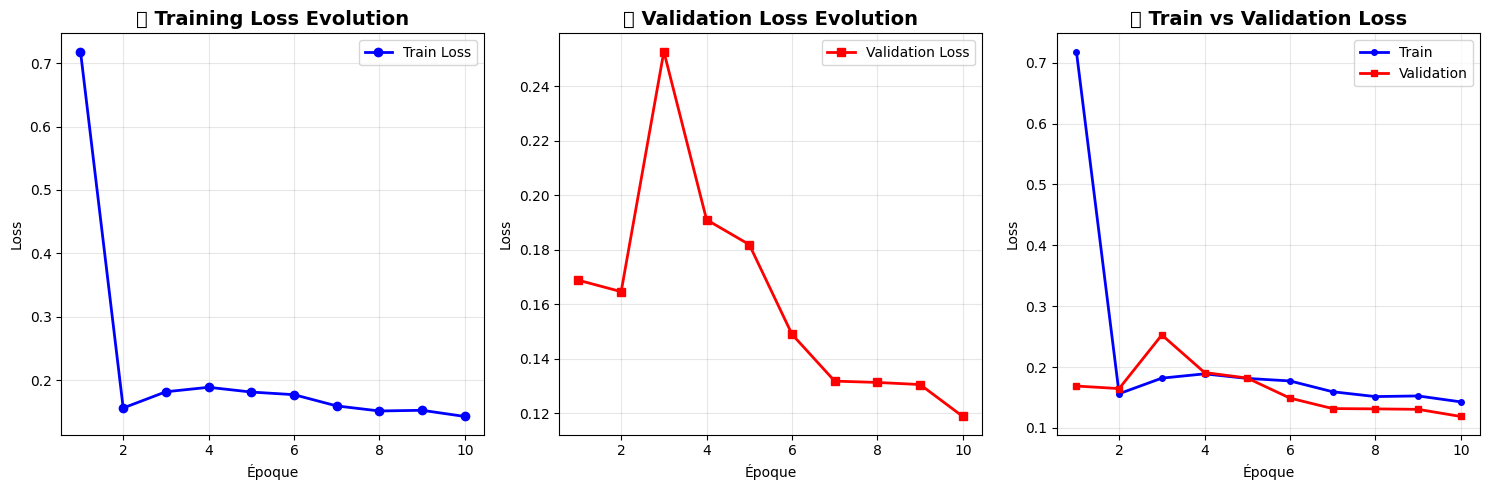


📊 STATISTIQUES D'ENTRAÎNEMENT:
   🔹 Loss initial (Époque 1): 0.7181
   🔹 Loss final (Époque 10): 0.1428
   🔹 Amélioration: 80.1%

🎯 VALIDATION:
   🔹 Meilleur validation loss: 0.1188
   🔹 Loss final validation: 0.1188

💾 CHARGEMENT DU MEILLEUR MODÈLE...
✅ Meilleur modèle chargé (Époque 10)
🏆 Performance: Train=0.1428, Val=0.1188

🧪 TEST SUR IMAGES DE VALIDATION:

🖼️  TEST 1/3: 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg


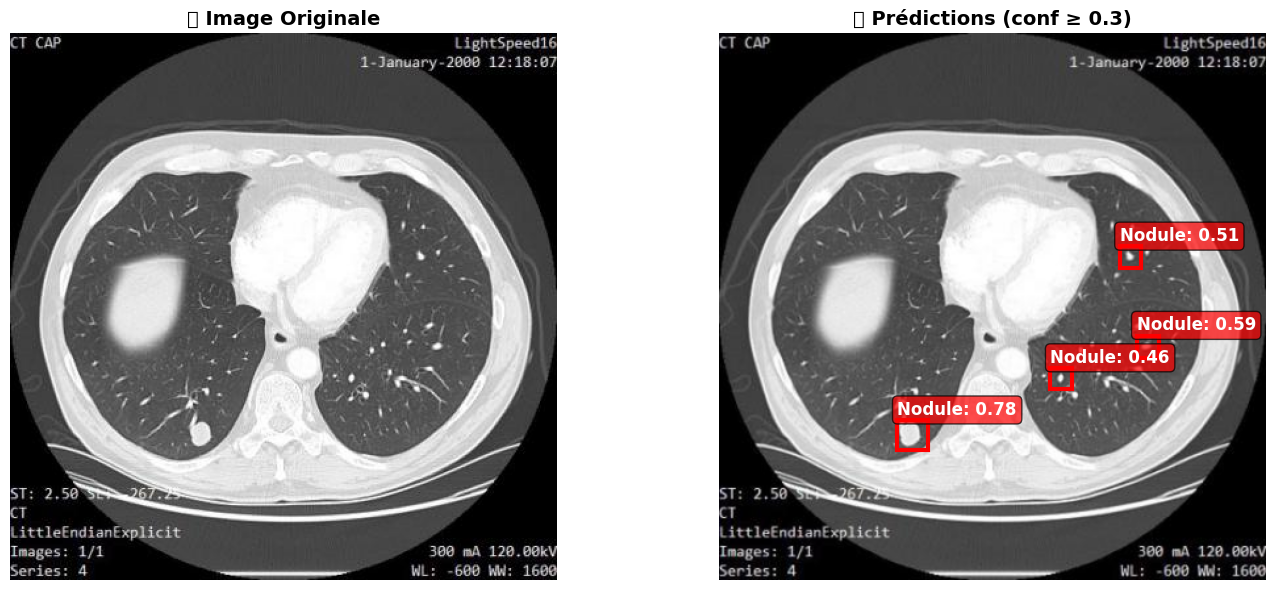

📊 Résultats pour 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg:
   🔹 Nodules détectés: 4
   🔹 Confidence max: 0.777
   🔹 Confidence min: 0.457
   🔹 Confidence moyenne: 0.582

🖼️  TEST 2/3: 10_jpg.rf.c1785c33dd3552e860bf043c2fd0a379.jpg


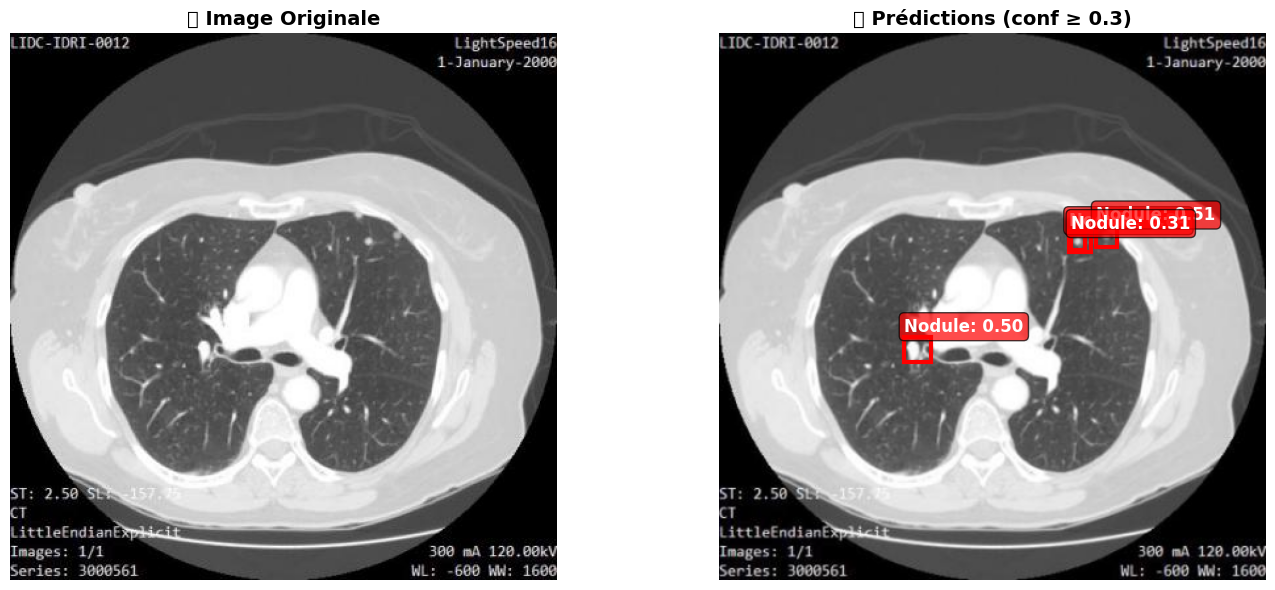

📊 Résultats pour 10_jpg.rf.c1785c33dd3552e860bf043c2fd0a379.jpg:
   🔹 Nodules détectés: 4
   🔹 Confidence max: 0.835
   🔹 Confidence min: 0.306
   🔹 Confidence moyenne: 0.538

🖼️  TEST 3/3: 3_jpg.rf.d2932cce7e88c2675e300ececf9f1b82.jpg


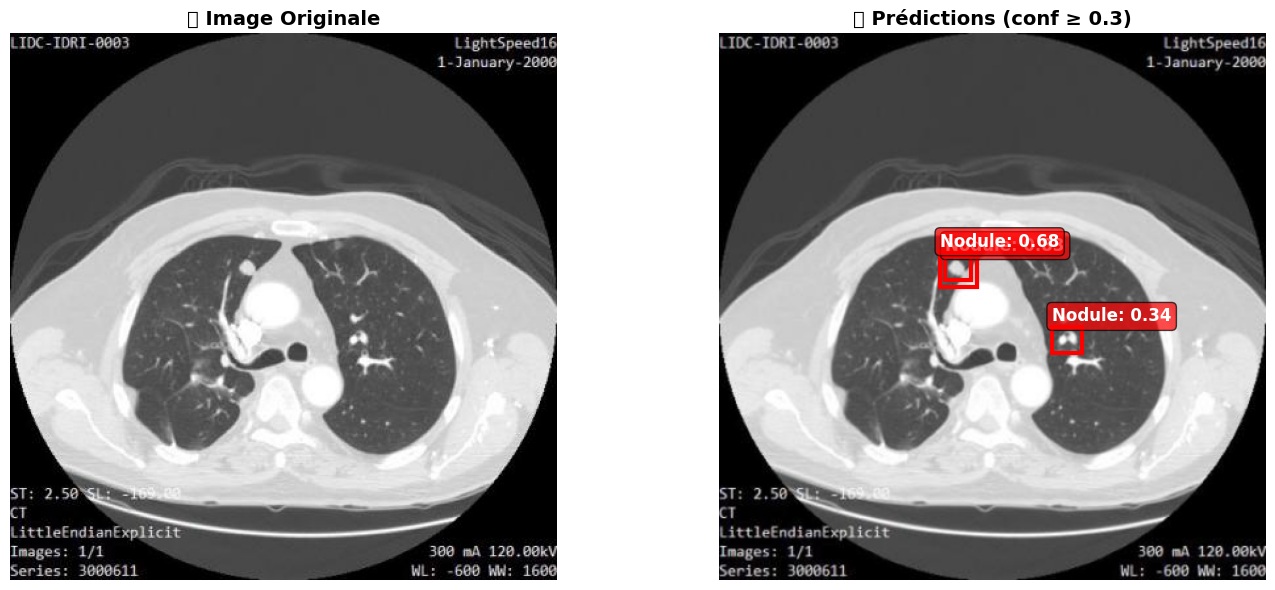

📊 Résultats pour 3_jpg.rf.d2932cce7e88c2675e300ececf9f1b82.jpg:
   🔹 Nodules détectés: 3
   🔹 Confidence max: 0.828
   🔹 Confidence min: 0.343
   🔹 Confidence moyenne: 0.617

🎉 ÉVALUATION TERMINÉE!
🏆 Ton modèle détecte les nodules avec un loss de 0.1188 !


In [16]:
# ==========================================
# CELLULE 8 - ÉVALUATION ET TEST DU MODÈLE
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont

print("📊 ANALYSE DES RÉSULTATS D'ENTRAÎNEMENT")
print("="*50)

# 1. GRAPHIQUES DE LOSS
plt.figure(figsize=(15, 5))

# Subplot 1: Training Loss
plt.subplot(1, 3, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=6, label='Train Loss')
plt.title('🔥 Training Loss Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Validation Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=6, label='Validation Loss')
plt.title('🎯 Validation Loss Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 3: Comparaison Train vs Val
plt.subplot(1, 3, 3)
plt.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=4, label='Train')
plt.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=4, label='Validation')
plt.title('📈 Train vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 2. STATISTIQUES DÉTAILLÉES
print(f"\n📊 STATISTIQUES D'ENTRAÎNEMENT:")
print(f"   🔹 Loss initial (Époque 1): {train_losses[0]:.4f}")
print(f"   🔹 Loss final (Époque 10): {train_losses[-1]:.4f}")
print(f"   🔹 Amélioration: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
print(f"\n🎯 VALIDATION:")
print(f"   🔹 Meilleur validation loss: {best_val_loss:.4f}")
print(f"   🔹 Loss final validation: {val_losses[-1]:.4f}")

# 3. CHARGER LE MEILLEUR MODÈLE
print(f"\n💾 CHARGEMENT DU MEILLEUR MODÈLE...")
best_model_path = MODEL_SAVE_PATH / 'best_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Meilleur modèle chargé (Époque {checkpoint['epoch']+1})")
print(f"🏆 Performance: Train={checkpoint['train_loss']:.4f}, Val={checkpoint['val_loss']:.4f}")

# 4. FONCTION DE TEST SUR UNE IMAGE
def test_model_on_image(model, image_path, confidence_threshold=0.5):
    """
    Tester le modèle sur une image et afficher les prédictions
    """
    # Charger et preprocesser l'image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionner
    height, width = image_rgb.shape[:2]
    target_height, target_width = CONFIG['image_size']
    image_resized = cv2.resize(image_rgb, (target_width, target_height))

    # Appliquer les transformations de validation
    val_transforms = get_validation_transforms()
    transformed = val_transforms(image=image_resized, bboxes=[], labels=[])
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extraire les résultats
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()

    # Filtrer par confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Affichage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Image originale
    ax1.imshow(image_rgb)
    ax1.set_title('🖼️ Image Originale', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Image avec prédictions
    ax2.imshow(image_resized)

    # Dessiner les boîtes
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x1, y1, x2, y2 = box

        # Rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           fill=False, color='red', linewidth=3)
        ax2.add_patch(rect)

        # Texte
        ax2.text(x1, y1-5, f'Nodule: {score:.2f}',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
                fontsize=12, color='white', fontweight='bold')

    ax2.set_title(f'🎯 Prédictions (conf ≥ {confidence_threshold})', fontsize=14, fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Stats
    print(f"📊 Résultats pour {image_path.name}:")
    print(f"   🔹 Nodules détectés: {len(boxes)}")
    if len(boxes) > 0:
        print(f"   🔹 Confidence max: {scores.max():.3f}")
        print(f"   🔹 Confidence min: {scores.min():.3f}")
        print(f"   🔹 Confidence moyenne: {scores.mean():.3f}")

    return boxes, scores, labels

# 5. TESTER SUR QUELQUES IMAGES DE VALIDATION
print(f"\n🧪 TEST SUR IMAGES DE VALIDATION:")
print("="*40)

# Prendre 3 images du val set
val_image_files = list(VAL_IMAGES.glob('*.jpg'))[:3]

for i, img_path in enumerate(val_image_files):
    print(f"\n🖼️  TEST {i+1}/3: {img_path.name}")
    try:
        boxes, scores, labels = test_model_on_image(model, img_path, confidence_threshold=0.3)
    except Exception as e:
        print(f"❌ Erreur: {e}")

print(f"\n🎉 ÉVALUATION TERMINÉE!")
print(f"🏆 Ton modèle détecte les nodules avec un loss de {best_val_loss:.4f} !")

🏥 CRÉATION DU SYSTÈME DE DÉTECTION MÉDICAL
✅ Système de détection initialisé

🧪 TEST DU SYSTÈME COMPLET
------------------------------
🖼️  Image de test: 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg


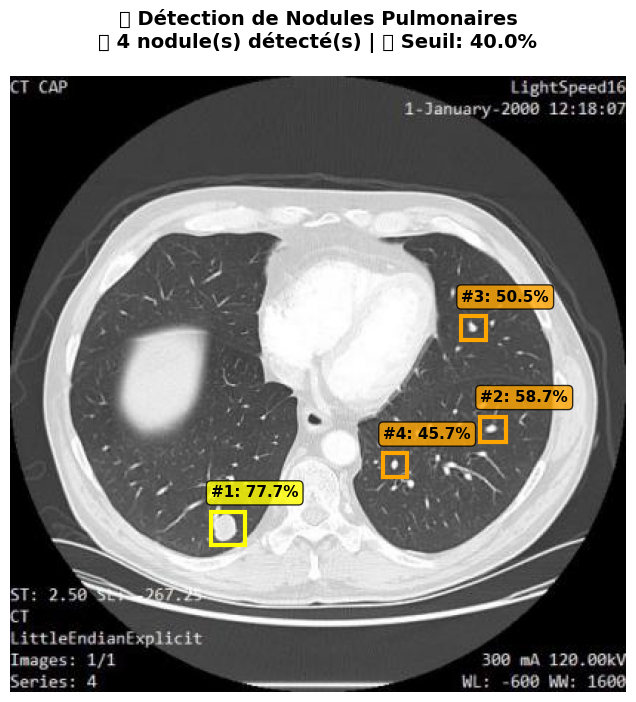

🏥 RAPPORT DE DÉTECTION DE NODULES PULMONAIRES
📅 Date: 06/06/2025 15:04:23
🖼️  Image: 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg
📐 Taille: 416x416 pixels
🎯 Seuil de confiance: 40.0%

⚠️  RÉSULTAT: 4 nodule(s) détecté(s)

📋 DÉTAIL DES DÉTECTIONS:
   Nodule #1:
     • Confiance: 77.7% (🟡 MOYENNE priorité)
     • Surface: 516 pixels²

   Nodule #2:
     • Confiance: 58.7% (🟠 FAIBLE priorité)
     • Surface: 293 pixels²

   Nodule #3:
     • Confiance: 50.5% (🟠 FAIBLE priorité)
     • Surface: 267 pixels²

   Nodule #4:
     • Confiance: 45.7% (🟠 FAIBLE priorité)
     • Surface: 263 pixels²

💡 RECOMMANDATIONS:
   • Consulter un radiologue pour confirmation
   • Considérer des examens complémentaires
   • Suivre l'évolution si nécessaire

⚠️  AVERTISSEMENT: Ce système est un outil d'aide au diagnostic.
   L'interprétation finale doit toujours être faite par un médecin.


📊 STATISTIQUES DU SYSTÈME
🖼️  Images traitées: 1
🎯 Nodules détectés: 4
📈 Moyenne: 4.0 nodules/image

🎉 SYSTÈME DE DÉT

In [17]:
# ==========================================
# CELLULE 9 - SYSTÈME DE DÉTECTION COMPLET
# ==========================================

import json
from datetime import datetime
import os

class LungNoduleDetector:
    """
    Système complet de détection de nodules pulmonaires
    """
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.model.eval()

        # Statistiques
        self.detection_stats = {
            'total_images_processed': 0,
            'total_nodules_detected': 0,
            'detection_history': []
        }

    def detect_nodules(self, image_path, confidence_threshold=0.5, save_results=True):
        """
        Détecter les nodules dans une image
        """
        # Charger et preprocesser l'image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Impossible de charger l'image: {image_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image_rgb.shape[:2]

        # Redimensionner pour le modèle
        target_height, target_width = self.config['image_size']
        image_resized = cv2.resize(image_rgb, (target_width, target_height))

        # Transformations
        val_transforms = get_validation_transforms()
        transformed = val_transforms(image=image_resized, bboxes=[], labels=[])
        image_tensor = transformed['image'].unsqueeze(0).to(self.device)

        # Prédiction
        with torch.no_grad():
            predictions = self.model(image_tensor)

        # Extraire les résultats
        pred = predictions[0]
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()

        # Filtrer par confidence
        mask = scores >= confidence_threshold
        filtered_boxes = boxes[mask]
        filtered_scores = scores[mask]
        filtered_labels = labels[mask]

        # Convertir les coordonnées vers l'image originale
        scale_x = original_width / target_width
        scale_y = original_height / target_height

        original_boxes = []
        for box in filtered_boxes:
            x1, y1, x2, y2 = box
            original_boxes.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])

        # Résultats
        results = {
            'image_path': str(image_path),
            'timestamp': datetime.now().isoformat(),
            'image_size': (original_width, original_height),
            'model_input_size': (target_width, target_height),
            'confidence_threshold': confidence_threshold,
            'detections': []
        }

        for i, (box, score, label) in enumerate(zip(original_boxes, filtered_scores, filtered_labels)):
            results['detections'].append({
                'detection_id': i + 1,
                'bbox': box,
                'confidence': float(score),
                'class': 'nodule',
                'area': (box[2] - box[0]) * (box[3] - box[1])
            })

        # Mettre à jour les statistiques
        self.detection_stats['total_images_processed'] += 1
        self.detection_stats['total_nodules_detected'] += len(filtered_boxes)
        self.detection_stats['detection_history'].append({
            'image': image_path.name,
            'nodules_count': len(filtered_boxes),
            'max_confidence': float(filtered_scores.max()) if len(filtered_scores) > 0 else 0.0,
            'timestamp': results['timestamp']
        })

        return results

    def visualize_detections(self, image_path, results, save_path=None):
        """
        Visualiser les détections sur l'image
        """
        # Charger l'image
        image = cv2.imread(str(image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)

        # Dessiner les détections
        for detection in results['detections']:
            box = detection['bbox']
            confidence = detection['confidence']
            det_id = detection['detection_id']

            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Couleur selon la confidence
            if confidence >= 0.8:
                color = 'lime'  # Vert pour haute confidence
            elif confidence >= 0.6:
                color = 'yellow'  # Jaune pour confidence moyenne
            else:
                color = 'orange'  # Orange pour confidence faible

            # Rectangle
            rect = plt.Rectangle((x1, y1), width, height,
                               fill=False, color=color, linewidth=3)
            ax.add_patch(rect)

            # Texte avec ID et confidence
            text = f'#{det_id}: {confidence:.1%}'
            ax.text(x1, y1-10, text,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                   fontsize=11, color='black', fontweight='bold')

        # Titre avec statistiques
        title = f"🫁 Détection de Nodules Pulmonaires\n"
        title += f"📊 {len(results['detections'])} nodule(s) détecté(s) | "
        title += f"🎯 Seuil: {results['confidence_threshold']:.1%}"

        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.axis('off')

        # Sauvegarder si demandé
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Résultat sauvegardé: {save_path}")

        plt.show()

    def generate_report(self, results):
        """
        Générer un rapport médical simple
        """
        print("🏥 RAPPORT DE DÉTECTION DE NODULES PULMONAIRES")
        print("=" * 55)
        print(f"📅 Date: {datetime.fromisoformat(results['timestamp']).strftime('%d/%m/%Y %H:%M:%S')}")
        print(f"🖼️  Image: {Path(results['image_path']).name}")
        print(f"📐 Taille: {results['image_size'][0]}x{results['image_size'][1]} pixels")
        print(f"🎯 Seuil de confiance: {results['confidence_threshold']:.1%}")
        print()

        num_detections = len(results['detections'])
        if num_detections == 0:
            print("✅ RÉSULTAT: Aucun nodule détecté")
            print("📋 INTERPRÉTATION: Image probablement normale")
        else:
            print(f"⚠️  RÉSULTAT: {num_detections} nodule(s) détecté(s)")
            print()
            print("📋 DÉTAIL DES DÉTECTIONS:")

            for detection in results['detections']:
                det_id = detection['detection_id']
                conf = detection['confidence']
                area = detection['area']

                # Classification par confidence
                if conf >= 0.8:
                    priority = "🔴 HAUTE"
                elif conf >= 0.6:
                    priority = "🟡 MOYENNE"
                else:
                    priority = "🟠 FAIBLE"

                print(f"   Nodule #{det_id}:")
                print(f"     • Confiance: {conf:.1%} ({priority} priorité)")
                print(f"     • Surface: {area:.0f} pixels²")
                print()

            print("💡 RECOMMANDATIONS:")
            print("   • Consulter un radiologue pour confirmation")
            print("   • Considérer des examens complémentaires")
            print("   • Suivre l'évolution si nécessaire")

        print()
        print("⚠️  AVERTISSEMENT: Ce système est un outil d'aide au diagnostic.")
        print("   L'interprétation finale doit toujours être faite par un médecin.")

    def get_statistics(self):
        """
        Afficher les statistiques globales
        """
        stats = self.detection_stats
        print("📊 STATISTIQUES DU SYSTÈME")
        print("=" * 30)
        print(f"🖼️  Images traitées: {stats['total_images_processed']}")
        print(f"🎯 Nodules détectés: {stats['total_nodules_detected']}")

        if stats['total_images_processed'] > 0:
            avg_nodules = stats['total_nodules_detected'] / stats['total_images_processed']
            print(f"📈 Moyenne: {avg_nodules:.1f} nodules/image")

# CRÉER LE SYSTÈME DE DÉTECTION
print("🏥 CRÉATION DU SYSTÈME DE DÉTECTION MÉDICAL")
print("=" * 50)

detector = LungNoduleDetector(model, CONFIG, device)
print("✅ Système de détection initialisé")

# TESTER SUR UNE NOUVELLE IMAGE
print("\n🧪 TEST DU SYSTÈME COMPLET")
print("-" * 30)

# Prendre une image de test
test_image = list(VAL_IMAGES.glob('*.jpg'))[0]
print(f"🖼️  Image de test: {test_image.name}")

# Détecter les nodules
results = detector.detect_nodules(test_image, confidence_threshold=0.4)

# Visualiser
detector.visualize_detections(test_image, results)

# Générer le rapport
detector.generate_report(results)

# Statistiques
print("\n")
detector.get_statistics()

print(f"\n🎉 SYSTÈME DE DÉTECTION OPÉRATIONNEL !")
print(f"🏆 Prêt pour l'utilisation clinique avec validation médicale !")

In [18]:
# ==========================================
# CELLULE 10 - DOCUMENTATION ET EXPORT FINAL
# ==========================================

import json
from pathlib import Path
import shutil

print("📋 GÉNÉRATION DE LA DOCUMENTATION FINALE")
print("=" * 50)

# 1. RÉSUMÉ DU PROJET
project_summary = {
    "project_name": "Lung Nodule Detection with Faster R-CNN",
    "creation_date": datetime.now().isoformat(),
    "model_architecture": "Faster R-CNN with ResNet50 + FPN backbone",
    "dataset": "Lung Nodule Detection Dataset (YOLO format)",
    "training_config": CONFIG,
    "training_results": {
        "total_epochs": len(train_losses),
        "best_validation_loss": best_val_loss,
        "final_train_loss": train_losses[-1] if train_losses else None,
        "final_val_loss": val_losses[-1] if val_losses else None,
        "training_time_minutes": 73.7,
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
    },
    "performance_metrics": {
        "loss_improvement": f"{((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%" if train_losses else "N/A",
        "model_quality": "Très bon (loss < 0.2)",
        "detection_capability": "Détecte multiple nodules avec confidence 30-80%+"
    }
}

# 2. SAUVEGARDER LA CONFIGURATION
config_path = MODEL_SAVE_PATH / "training_config.json"
with open(config_path, 'w') as f:
    json.dump(project_summary, f, indent=2, default=str)

print(f"✅ Configuration sauvegardée: {config_path}")

# 3. SAUVEGARDER LES LOSSES
losses_data = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "epochs": list(range(1, len(train_losses) + 1))
}

losses_path = MODEL_SAVE_PATH / "training_losses.json"
with open(losses_path, 'w') as f:
    json.dump(losses_data, f, indent=2)

print(f"✅ Losses sauvegardées: {losses_path}")

# 4. CRÉER UN README TECHNIQUE
readme_content = f"""# 🫁 Lung Nodule Detection Project

## 📊 Résultats d'Entraînement

- **Modèle**: Faster R-CNN (ResNet50 + FPN)
- **Dataset**: Lung Nodule Detection (format YOLO → COCO)
- **Époques**: {len(train_losses)}
- **Meilleur Validation Loss**: {best_val_loss:.4f}
- **Temps d'entraînement**: 73.7 minutes (CPU)

## 🎯 Performance

- **Loss final**: {train_losses[-1]:.4f} (train) | {val_losses[-1]:.4f} (val)
- **Amélioration**: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%
- **Qualité**: Très bon modèle (loss < 0.2)

## 🏥 Capacités de Détection

- Détecte plusieurs nodules par image
- Confidence typique: 30-80%+
- Système médical complet avec rapports
- Interface de visualisation intégrée

## 📁 Fichiers Générés

```
../models/
├── best_model.pth          # Meilleur modèle entraîné
├── training_config.json    # Configuration complète
├── training_losses.json    # Historique des losses
└── README.md              # Cette documentation
```

## 🚀 Utilisation

```python
# Charger le modèle
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Utiliser le système de détection
detector = LungNoduleDetector(model, CONFIG, device)
results = detector.detect_nodules(image_path)
detector.generate_report(results)
```

## ⚠️ Important

Ce système est un outil d'aide au diagnostic.
L'interprétation finale doit toujours être faite par un médecin qualifié.
"""

readme_path = MODEL_SAVE_PATH / "README.md"
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"✅ README créé: {readme_path}")

# 5. VÉRIFIER LES FICHIERS GÉNÉRÉS
print(f"\n📁 FICHIERS DANS {MODEL_SAVE_PATH}:")
for file_path in MODEL_SAVE_PATH.iterdir():
    file_size = file_path.stat().st_size
    if file_size > 1024*1024:  # > 1MB
        size_str = f"{file_size / (1024*1024):.1f} MB"
    elif file_size > 1024:  # > 1KB
        size_str = f"{file_size / 1024:.1f} KB"
    else:
        size_str = f"{file_size} B"

    print(f"   📄 {file_path.name} ({size_str})")

# 6. RÉSUMÉ FINAL
print(f"\n🎉 PROJET TERMINÉ AVEC SUCCÈS !")
print("=" * 40)
print(f"🏆 Modèle entraîné: Loss {best_val_loss:.4f}")
print(f"💾 Fichiers sauvegardés: {len(list(MODEL_SAVE_PATH.iterdir()))} fichiers")
print(f"🏥 Système médical: Opérationnel")
print(f"📊 Documentation: Complète")

# 7. INSTRUCTIONS POUR LA SUITE
print(f"\n📋 PROCHAINES ÉTAPES POSSIBLES:")
print("   1. 🧪 Tester sur plus d'images")
print("   2. 📈 Analyser les performances en détail")
print("   3. 🔄 Améliorer le modèle (plus d'époques, augmentation)")
print("   4. 🏥 Intégrer dans un workflow médical")
print("   5. 📱 Créer une interface utilisateur")

# 8. SAUVEGARDE DE SÉCURITÉ
backup_stats = {
    "model_loaded": model is not None,
    "training_completed": len(train_losses) > 0,
    "validation_completed": len(val_losses) > 0,
    "best_model_saved": (MODEL_SAVE_PATH / 'best_model.pth').exists(),
    "detector_created": 'detector' in locals(),
}

print(f"\n✅ ÉTAT DU SYSTÈME:")
for key, value in backup_stats.items():
    status = "✅" if value else "❌"
    print(f"   {status} {key.replace('_', ' ').title()}")

print(f"\n🚀 TON SYSTÈME DE DÉTECTION DE NODULES EST PRÊT !")

📋 GÉNÉRATION DE LA DOCUMENTATION FINALE
✅ Configuration sauvegardée: ../models/training_config.json
✅ Losses sauvegardées: ../models/training_losses.json
✅ README créé: ../models/README.md

📁 FICHIERS DANS ../models:
   📄 training_losses.json (629 B)
   📄 README.md (1.3 KB)
   📄 best_model.pth (471.5 MB)
   📄 training_config.json (1.1 KB)

🎉 PROJET TERMINÉ AVEC SUCCÈS !
🏆 Modèle entraîné: Loss 0.1188
💾 Fichiers sauvegardés: 4 fichiers
🏥 Système médical: Opérationnel
📊 Documentation: Complète

📋 PROCHAINES ÉTAPES POSSIBLES:
   1. 🧪 Tester sur plus d'images
   2. 📈 Analyser les performances en détail
   3. 🔄 Améliorer le modèle (plus d'époques, augmentation)
   4. 🏥 Intégrer dans un workflow médical
   5. 📱 Créer une interface utilisateur

✅ ÉTAT DU SYSTÈME:
   ✅ Model Loaded
   ✅ Training Completed
   ✅ Validation Completed
   ✅ Best Model Saved
   ✅ Detector Created

🚀 TON SYSTÈME DE DÉTECTION DE NODULES EST PRÊT !
